<a href="https://colab.research.google.com/github/humairahs/UNet-for-hippocampus-MRI-segmentation/blob/main/refined_basic_and_attention_unet_segmentation_hippocampus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ABOUT**
Alzheimer disease refers to a condition related to brain where brain cells are dead and can result in various issues, such as dementia and cognitive decline and it is associated with certain part of the brain, namely hippocampus [3]. By performing image segmentation and analysis of hippocampus, early detection of Alzheimer is possible. However, traditional way to segment image is dependant on the clinicians and is not accurate [4]. With the emergence of artificial intelligence as well as computer-aided technology, it opens up the possibility of new ways to perform image segmentation. This research aims to experiment to create an automatic segmentation system for hippocampus gland region. Hopefully, this system can support clinicians in early detection of Alzheimer by providing accurate segmentation, offering time and resource efficiency.

***> DESCRIPTION OF TASK:***
 To create a method for automatic segmentation of hippocampus glands based on MRI slices using U-Net architecture.

***> DESCRIPTION OF DATASET:***
The dataset used in this research is obtained from research conducted by Boccardi et al.[1], and accessed through Kaggle platform [2].
The dataset contains MRI from 135 Alzheimer patients, as well as their corresponding mask of hippocampus glands, done by using Hippocampal Harmonized Protocols (HHP) with a slice thickness of 1.2 mm in sagittal orientation [1]

***> METHODS:***
This work will use U-Net CNN architecture to perform the segmentation, with the flow is as follows:
*   Data handling: cleaning & mask alignment, contrast enhancement & normalization, patient-level split, data augmentation
*   Model creation & training: basic UNet & attention UNet
*   Model testing
*   K-fold crossvalidation

***REFERENCES:***
1.   Boccardi, M., Bocchetta, M., Morency, F. C., Collins, D. L., Nishikawa, M., Ganzola, R., Grothe, M. J., Wolf, D., Redolfi, A., Pievani, M., Antelmi, L., Fellgiebel, A., Matsuda, H., Teipel, S., Duchesne, S., Jack, C. R., Jr, Frisoni, G. B., & EADC-ADNI Working Group on The Harmonized Protocol for Manual Hippocampal Segmentation and for the Alzheimer's Disease Neuroimaging Initiative (2015). Training labels for hippocampal segmentation based on the EADC-ADNI harmonized hippocampal protocol. Alzheimer's & dementia : the journal of the Alzheimer's Association, 11(2), 175–183. https://doi.org/10.1016/j.jalz.2014.12.002
2.   Saber Malekzadeh. (2019). MRI Hippocampus Segmentation [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DS/400588
3. Balasundaram A, Srinivasan S, Prasad A, Malik J, Kumar A. Hippocampus Segmentation-Based Alzheimer's Disease Diagnosis and Classification of MRI Images. Arab J Sci Eng. 2023 Jan 3:1-17. doi: 10.1007/s13369-022-07538-2. Epub ahead of print. PMID: 36619218; PMCID: PMC9810248.
4. Hazarika RA, Maji AK, Syiem R, Sur SN, Kandar D. Hippocampus Segmentation Using U-Net Convolutional Network from Brain Magnetic Resonance Imaging (MRI). J Digit Imaging. 2022 Aug;35(4):893-909. doi: 10.1007/s10278-022-00613-y. Epub 2022 Mar 18. PMID: 35304675; PMCID: PMC9485390.




# Import libraries & data

In [1]:
# Importing necessary libraries for the task

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from pathlib import Path
from tensorflow import keras
from keras import layers, Model
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, LeakyReLU, Softmax, Input, BatchNormalization, MaxPooling2D, Conv2DTranspose, Dropout,
                            UpSampling2D, concatenate, Lambda)
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import KFold, GroupShuffleSplit
import seaborn as sns
import pandas as pd


In [2]:
# Data saved in personal drive mounted to be worked on in this colabolatory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q '/content/drive/MyDrive/EMMBIOME/dataset/sabermalekmrihs.zip' -d '/content/dataset/'
path_folder = '/content/dataset/'

In [4]:
# The images and masks are within label & original folder respectively

label_path = '/content/dataset/label/'
image_path = '/content/dataset/original/'

label_list_path = list(Path(label_path).glob(r"**/*.jpg"))  #List of path of all masks
image_list_path = list(Path(image_path).glob(r"**/*.jpg"))  #List of path of all images

# all data
len(image_list_path), len(label_list_path)

(25515, 50841)

In [5]:
# The number of image and mask is different. Below shows the image & mask are not corresponding to each other for the same index

print(label_list_path[0])
print(image_list_path[0])

/content/dataset/label/35label/ADNI_012_S_1321_99348_ACPC/ADNI_012_S_1321_99348_R/ADNI_012_S_1321_99348_R_138.jpg
/content/dataset/original/35/ADNI_012_S_1321_99348_ACPC/ADNI_012_S_1321_99348_ACPC_078.jpg


## Handling correct pairs of img & mask

In [6]:
# Categorize label_list_path to label_list_left and label_list_right

label_list_left = []
label_list_right = []

for label_path in label_list_path:
  path = str(label_path)
  if path[-9] == 'L':
    label_list_left.append(path)
  elif path[-9] == 'R':
    label_list_right.append(path)

In [7]:
image_list = [str(a) for a in image_list_path]

In [8]:
'''
The mask is supposed to consist of left (L) and right (R) part of hippocampus segmentation. However, some masks do not have
corresponding part. To ensure that each image has complete mask, and all masks correspond to an image, we filter it & keep
only those having complete pieces.
'''

def extract_key(string):
  s = string.split('/')[-1]
  parts = s.split('_')
  key = '_'.join(parts[:5] + parts[-1:])
  return key

dict_L = {extract_key(s): s for s in label_list_left}
dict_R = {extract_key(s): s for s in label_list_right}
dict_image = {extract_key(s): s for s in image_list}

common_keys = set(dict_L.keys()) & set(dict_R.keys()) & set(dict_image.keys())

filtered_label_L = [dict_L[key] for key in common_keys]
filtered_label_R = [dict_R[key] for key in common_keys]
filtered_list_image = [dict_image[key] for key in common_keys]

filtered_label_L.sort()
filtered_label_R.sort()
filtered_list_image.sort()

m = 5000
filtered_label_L[m], filtered_label_R[m], filtered_list_image[m]

('/content/dataset/label/100label/ADNI_007_S_4387_269929_ACPC/ADNI_007_S_4387_269929_L/ADNI_007_S_4387_269929_L_087.jpg',
 '/content/dataset/label/100label/ADNI_007_S_4387_269929_ACPC/ADNI_007_S_4387_269929_R/ADNI_007_S_4387_269929_R_087.jpg',
 '/content/dataset/original/100/ADNI_007_S_4387_269929_ACPC/ADNI_007_S_4387_269929_ACPC_087.jpg')

In [9]:
def get_patient_id(path):
    fname = os.path.basename(path)
    parts = fname.split('_')
    return '_'.join(parts[:5])

patient_ids = np.array([get_patient_id(p) for p in filtered_label_L])
print("Unique patients:", len(np.unique(patient_ids)))


Unique patients: 134


# Helper functions


In [10]:
def padding_image(img):
  top = 12
  bottom = 11
  left = 30
  right = 29

  padded_img = np.pad(img, ((top, bottom), (left, right)), 'constant', constant_values = 0)
  return padded_img

In [11]:
def crop_image(image):
    height, width = image.shape     #(233, 197)
    newshape = 128
    center_y = int(np.ceil(height/2))
    center_x = int(np.ceil(width/2))
    start_y = center_y - newshape//2
    end_y = center_y + newshape//2
    start_x = center_x - newshape//2
    end_x = center_x + newshape//2
    cropped_image = image[start_y:end_y, start_x:end_x]
    return cropped_image

In [12]:
from keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    verbose = 1,
    mode = 'min',
    restore_best_weights = True
)

# Load mask

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)
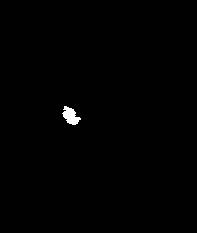

In [13]:
# Sample of mask

image = cv2.imread(filtered_label_L[70])
image

In [14]:
# Concatenating L and R masks so each image has a single union mask

list_concat = []
for i in range(len(filtered_label_L)):
    left = cv2.imread(filtered_label_L[i], cv2.IMREAD_GRAYSCALE) / 255.0
    right = cv2.imread(filtered_label_R[i], cv2.IMREAD_GRAYSCALE) / 255.0
    img_left = (left > 0.5).astype(np.uint8)
    img_right = (right > 0.5).astype(np.uint8)
    # concat = cv2.addWeighted(img_left, 0.5, img_right, 0.5, 0)
    # img_concat = (concat/255 > 0.5).astype(np.ui
    img_concat = np.clip(img_left + img_right, 0, 1).astype(np.uint8)

    padded_img_concat = padding_image(img_concat)
    list_concat.append(padded_img_concat)

label_concat = np.array(list_concat)


# Load original image


In [15]:
# The original image is not in square shape, so we pad it. The final size of image is (256,256)

list_image = []
for path in filtered_list_image:
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

  padded_img = padding_image(img)
  list_image.append(padded_img)
images = np.array(list_image)

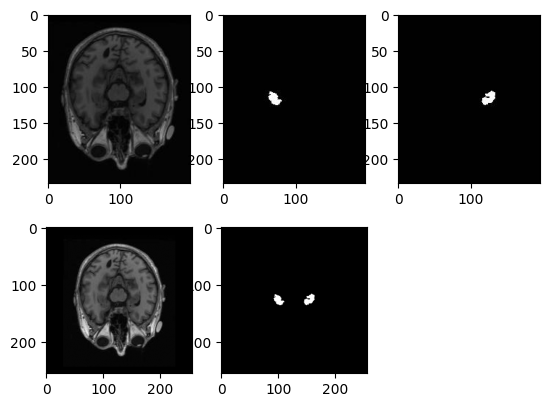

In [16]:
# Display sample of data index-70 of its original & new shape, and mask before and after concatenation

idx = 70
# idx = random.randint(0, len(filtered_list_image)-1)
plt.figure()
plt.subplot(2,3,1)
plt.imshow(cv2.imread(filtered_list_image[idx]))
plt.subplot(2,3,2)
plt.imshow(cv2.imread(filtered_label_L[idx]))
plt.subplot(2,3,3)
plt.imshow(cv2.imread(filtered_label_R[idx]))
plt.subplot(2,3,4)
plt.imshow(images[idx], cmap='gray')
plt.subplot(2,3,5)
plt.imshow(label_concat[idx], cmap='gray');


In [17]:
# Original size of dataset after being cleaned: 25326 images & masks
images.shape, label_concat.shape, patient_ids.shape

((25326, 256, 256), (25326, 256, 256), (25326,))

In [18]:
len(np.unique(patient_ids))

134

In [19]:
# # Due to limited computational resource, data is reduced. We only select the equal number of data of those having segmented part
# # and not (fully black in mask)

rng = np.random.default_rng(42)
unique_patients = np.unique(patient_ids)
selected_indices_per_patient = []
for pid in unique_patients:
    patient_idx = np.where(patient_ids == pid)[0]
    patient_masks = label_concat[patient_idx]                  # (n_slices, 256, 256)
    has_hippo = (patient_masks.max(axis=(1, 2)) > 0)
    pos_idx = patient_idx[has_hippo]       # slices with hippocampus
    neg_idx = patient_idx[~has_hippo]      # slices with all-black mask
    n_pos = len(pos_idx)
    n_neg = len(neg_idx)

    # If this patient has no hippocampal slices, skip them (rare but safe)
    if n_pos == 0:
        continue
    if n_neg >= n_pos:
        neg_selected = rng.choice(neg_idx, size=n_pos, replace=False)
    else:
        neg_selected = neg_idx

    patient_selected = np.concatenate([pos_idx, neg_selected])
    selected_indices_per_patient.append(patient_selected)

selected_idx = np.concatenate(selected_indices_per_patient)

# rng.shuffle(selected_idx)

selected_mask       = label_concat[selected_idx]
selected_image      = images[selected_idx]
selected_patient_id = patient_ids[selected_idx]


# Preprocess original image

In [20]:
selected_mask.shape, selected_image.shape, selected_patient_id.shape, selected_image.dtype

((8048, 256, 256), (8048, 256, 256), (8048,), dtype('uint8'))

In [21]:
# The number of patient in the filtered data

len(np.unique(selected_patient_id))

134

## **Histogram equalization*

In [22]:
# CLAHE
def clahe(img):
  return cv2.createCLAHE().apply(img)


# Sharpening to enhance the edge/boundaries within objects in image
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
def sharpen(img):
  return cv2.filter2D(img, ddepth=-1, kernel=kernel)

In [23]:
# Histogram equalization

def plot_histogram(img):
  plt.hist(img.flatten(), 256, range=[0,256], color='r')
  plt.xlim([0,256])
  plt.xlabel('Intensity')
  plt.ylabel('Number of pixels')
  plt.show()

def plot_histeq(img):
  img = histeq(img)
  plt.hist(img.flatten(), 256, range=[0,256], color='r')
  plt.xlim([0,256])
  plt.xlabel('Intensity')
  plt.ylabel('Number of pixels')
  plt.show()

def histeq(img):
  return cv2.equalizeHist(img)



## **Smoothing*

In [24]:
# Bilinear smoothing to preserve edge

def smoothing(img, diameter=3):
  return cv2.bilateralFilter(img,diameter,75,75)

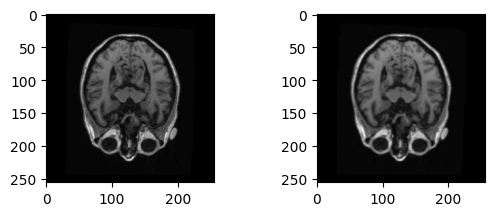

In [25]:
idx = 70

plt.subplot(2,2,1)
plt.imshow(selected_image[idx], cmap='gray')
plt.subplot(2,2,2)
plt.imshow(smoothing(selected_image[idx]), cmap='gray')   # bilateral-smoothed image
plt.show()

## *Combined preprocessing methods*
Perform trial-error to find the best combination of preprocessing methods for the model later. For example, we started by trying to train model with original data, then by histogram equalized data, and until some combinations of methods to get some variations of preprocessed data.

In [26]:
# preprocessed_image = selected_image
# preprocessed_image = np.array([sharpen(clahe(img)) for img in selected_image])
preprocessed_image = np.array([clahe(img) for img in selected_image])
# preprocessed_image = np.array([sharpen(smoothing(clahe(img),3)) for img in selected_image])
# preprocessed_image = np.array([clahe(smoothing(img,3)) for img in selected_image])
# preprocessed_image = np.array([smoothing(clahe(img),3) for img in selected_image])

In [27]:
preprocessed_image = preprocessed_image.astype(np.float32)/255.0

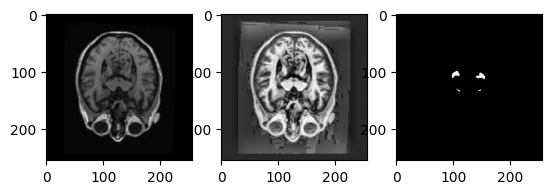

In [28]:
idx = 70
plt.subplot(1,3,1)
plt.imshow(selected_image[idx], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(preprocessed_image[idx], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(selected_mask[idx], cmap='gray')
plt.show()

# Prepare data for model

In [29]:
x = np.expand_dims(preprocessed_image, 3)
y = np.expand_dims(selected_mask, 3)

In [30]:
EPOCH = 30
BATCH_SIZE = 32
learning_rate = 0.0005
SEED = 42

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

## Patient-level data split

In [31]:
def split_data_patient(patient_ids, train_size=0.8, val_size=0.1, seed=42):
    unique_patients = np.unique(patient_ids)
    rng = np.random.default_rng(seed)
    rng.shuffle(unique_patients)
    n = len(unique_patients)
    n_train = int(train_size*n)
    n_val = int(val_size*n)

    train_patients = unique_patients[:n_train]
    val_patients = unique_patients[n_train : n_train+n_val]
    test_patients = unique_patients[n_train+n_val:]

    train_mask = np.isin(patient_ids, train_patients)
    val_mask = np.isin(patient_ids, val_patients)
    test_mask = np.isin(patient_ids, test_patients)
    train_idx = np.where(train_mask)[0]
    val_idx = np.where(val_mask)[0]
    test_idx = np.where(test_mask)[0]

    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = split_data_patient(selected_patient_id)

X_train, X_val, X_test = x[train_idx], x[val_idx], x[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (6416, 256, 256, 1), (6416, 256, 256, 1)
Validation set: (776, 256, 256, 1), (776, 256, 256, 1)
Test set: (856, 256, 256, 1), (856, 256, 256, 1)


In [32]:
def augment_pair(image, mask):
    # Right left flip
    flip_lr = tf.random.uniform(()) > 0.5
    image = tf.cond(flip_lr, lambda: tf.image.flip_left_right(image), lambda: image)
    mask = tf.cond(flip_lr, lambda: tf.image.flip_left_right(mask), lambda: mask)

    # # Up down flip
    # flip_ud = tf.random.uniform(()) > 0.5
    # image = tf.cond(flip_ud, lambda: tf.image.flip_up_down(image), lambda: image)
    # mask = tf.cond(flip_ud, lambda: tf.image.flip_up_down(mask), lambda: mask)

    # # Random rotation
    # k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    # image = tf.image.rot90(image, k)
    # mask  = tf.image.rot90(mask, k)

    return image, mask

def make_train_dataset(X, Y, batch_size=32, augment=True):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.shuffle(buffer_size=len(X), reshuffle_each_iteration=True)
    if augment:
        ds = ds.map(augment_pair, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

def make_test_dataset(X, Y, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [33]:
train_ds = make_train_dataset(X_train, y_train, batch_size=BATCH_SIZE, augment=True)
# test_ds  = make_test_dataset(X_test,  y_test,  batch_size=BATCH_SIZE)


## helpers

In [34]:
def plot_train1(history):
    plt.figure(figsize=(15, 5))

    # IoU (metric)
    plt.subplot(1, 3, 1)
    plt.plot(history.history['metric_iou'], label='Training IoU', color='blue')
    if 'val_metric_iou' in history.history:
        plt.plot(history.history['val_metric_iou'], label='Validation IoU', color='cyan')
    plt.title('Model IoU Score')
    plt.xlabel('Epoch')
    plt.ylabel('IoU score')
    plt.legend(loc='lower right')

    # Dice (metric)
    plt.subplot(1, 3, 2)
    plt.plot(history.history['metric_dice'], label='Training Dice', color='blue')
    if 'val_metric_dice' in history.history:
        plt.plot(history.history['val_metric_dice'], label='Validation Dice', color='cyan')
    plt.title('Model DIce Score')
    plt.xlabel('Epoch')
    plt.ylabel('Dice score')
    plt.legend(loc='lower right')

    # Loss
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'], label='Training Loss', color='red')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


def plot_test(model, X_test=X_test, y_test=y_test):
    for i in range(1, 5):
        test_img_number = random.randint(0, len(X_test)-1)
        test_img = X_test[test_img_number]
        ground_truth=y_test[test_img_number]
        test_img_norm=test_img[:,:,0][:,:,None]
        test_img_input=np.expand_dims(test_img_norm, 0)
        prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
        plt.figure(figsize=(16, 8))
        plt.subplot(2,3,1)
        plt.title('Original test image')
        plt.imshow(test_img[:,:,0], cmap='gray')
        plt.subplot(2,3,2)
        plt.title('Ground truth')
        plt.imshow(ground_truth[:,:,0], cmap='gray')
        plt.subplot(2,3,3)
        plt.title('U-Net prediction')
        plt.imshow(prediction, cmap='gray')

# def test_model1(model, X_test, y_test, threshold=0.5):
#     # X_test = np.array([preprocess(img) for img in X_test])
#     y_pred=model.predict(X_test)
#     y_pred = y_pred > threshold

#     iou = iou_score_np(y_test, y_pred)
#     dice = dice_coef_np(y_test, y_pred)

#     return iou, dice


In [35]:
def metric_dice(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_bin = tf.cast(y_true > 0.5, tf.float32)
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    y_true_f = tf.reshape(y_true_bin, [-1])
    y_pred_f = tf.reshape(y_pred_bin, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    denominator = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2.0 * intersection + smooth) / (denominator + smooth)
    return dice


def metric_iou(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_bin = tf.cast(y_true > 0.5, tf.float32)
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    y_true_f = tf.reshape(y_true_bin, [-1])
    y_pred_f = tf.reshape(y_pred_bin, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou


In [38]:
def eval_model(model, X_test, y_test):
    loss, iou, dice = model.evaluate(
                        X_test,
                        y_test,
                        batch_size=BATCH_SIZE,
                        verbose=0 )
    return loss, iou, dice

# UNet Model

In [39]:
class UNet1:
    def __init__(self,
                 base_filters=16,
                 dropout_rate=0.1,
                 activation='relu',
                 kernel_initializer='he_normal',
                 use_batchnorm=True):
        self.base_filters = base_filters
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.kernel_initializer = kernel_initializer
        self.use_batchnorm = use_batchnorm

    def conv_block(self, x, filters):
        x = layers.Conv2D(filters, (3, 3), activation=self.activation, kernel_initializer=self.kernel_initializer, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3, 3), activation=self.activation, kernel_initializer=self.kernel_initializer, padding='same')(x)
        x = layers.BatchNormalization()(x)
        return x

    def build_unet(self, img_height, img_width, img_channels):
        f  = self.base_filters
        dropout_rate = self.dropout_rate
        s  = Input(shape=(img_height, img_width, img_channels))

        # Encoder
        c1 = self.conv_block(s, f)
        p1 = layers.MaxPooling2D((2, 2))(c1)
        p1 = layers.Dropout(0.2)(p1)

        c2 = self.conv_block(p1, f * 2)
        p2 = layers.MaxPooling2D((2, 2))(c2)
        p2 = layers.Dropout(0.2)(p2)

        c3 = self.conv_block(p2, f * 4)
        p3 = layers.MaxPooling2D((2, 2))(c3)
        p3 = layers.Dropout(0.2)(p3)

        c4 = self.conv_block(p3, f * 8)
        p4 = layers.MaxPooling2D((2, 2))(c4)
        p4 = layers.Dropout(0.3)(p4)

        c5 = self.conv_block(p4, f * 16)
        p5 = layers.MaxPooling2D((2, 2))(c5)
        p5 = layers.Dropout(0.4)(p5)

        # Bottleneck
        c6 = self.conv_block(p5, f * 32)
        c6 = layers.Dropout(0.4)(c6)

        # Decoder
        u7 = layers.Conv2DTranspose(f * 16, (2, 2), strides=(2, 2), padding='same')(c6)
        u7 = layers.Concatenate()([u7, c5])
        u7 = layers.Dropout(0.4)(u7)
        c7 = self.conv_block(u7, f * 16)

        u8 = layers.Conv2DTranspose(f * 8, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = layers.Concatenate()([u8, c4])
        u8 = layers.Dropout(0.3)(u8)
        c8 = self.conv_block(u8, f * 8)

        u9 = layers.Conv2DTranspose(f * 4, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = layers.Concatenate()([u9, c3])
        u9 = layers.Dropout(0.2)(u9)
        c9 = self.conv_block(u9, f * 4)

        u10 = layers.Conv2DTranspose(f * 2, (2, 2), strides=(2, 2), padding='same')(c9)
        u10 = layers.Concatenate()([u10, c2])
        u10 = layers.Dropout(0.2)(u10)
        c10 = self.conv_block(u10, f * 2)

        u11 = layers.Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(c10)
        u11 = layers.Concatenate()([u11, c1])
        u11 = layers.Dropout(0.2)(u11)
        c11 = self.conv_block(u11, f)

        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)
        model = Model(inputs=s, outputs=outputs)
        return model

In [40]:
unet = UNet1(base_filters=16)
model = unet.build_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)


In [41]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]  

 Total params: 7,787,345 (29.71 MB)

 Trainable params: 7,781,329 (29.68 MB)

 Non-trainable params: 6,016 (23.50 KB)

In [42]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
               loss = 'binary_crossentropy',
               metrics = [metric_iou, metric_dice])
history = model.fit(train_ds,
                    # X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    epochs = EPOCH)#,shuffle = True)


Epoch 1/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 89s 206ms/step - loss: 0.6634 - metric_dice: 0.0029 - metric_iou: 0.0015 - val_loss: 0.3971 - val_metric_dice: 0.1200 - val_metric_iou: 0.1200
Epoch 2/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.3527 - metric_dice: 2.6003e-04 - metric_iou: 1.3083e-04 - val_loss: 0.1686 - val_metric_dice: 0.1200 - val_metric_iou: 0.1200
Epoch 3/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.1539 - metric_dice: 1.0807e-04 - metric_iou: 5.4214e-05 - val_loss: 0.0789 - val_metric_dice: 0.1200 - val_metric_iou: 0.1200
Epoch 4/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0723 - metric_dice: 0.2164 - metric_iou: 0.1514 - val_loss: 0.0417 - val_metric_dice: 0.5136 - val_metric_iou: 0.3966
Epoch 5/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0386 - metric_dice: 0.7105 - metric_iou: 0.5520 - val_loss: 0.0253 - val_metric_dice: 0.6710 - val_metric_iou: 0.5433
Epoch 6/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0237 - me

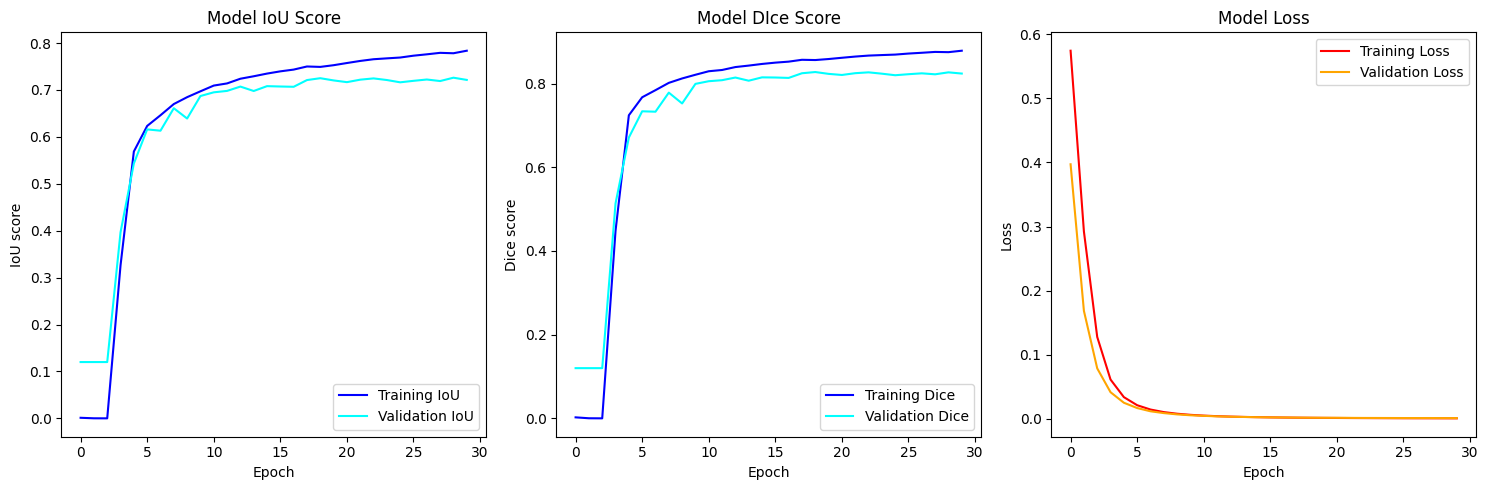

In [43]:
plot_train1(history)

In [44]:
eval_model(model, X_test, y_test)


(0.0010896804742515087, 0.7370366454124451, 0.834997296333313)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


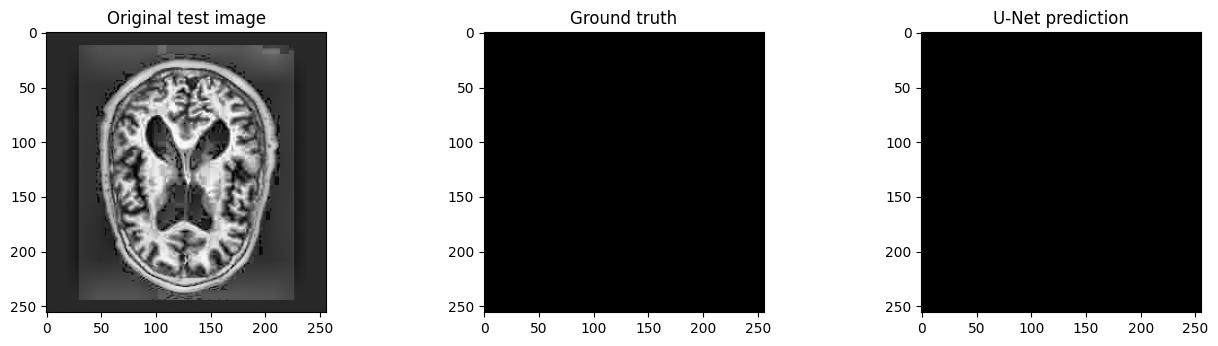

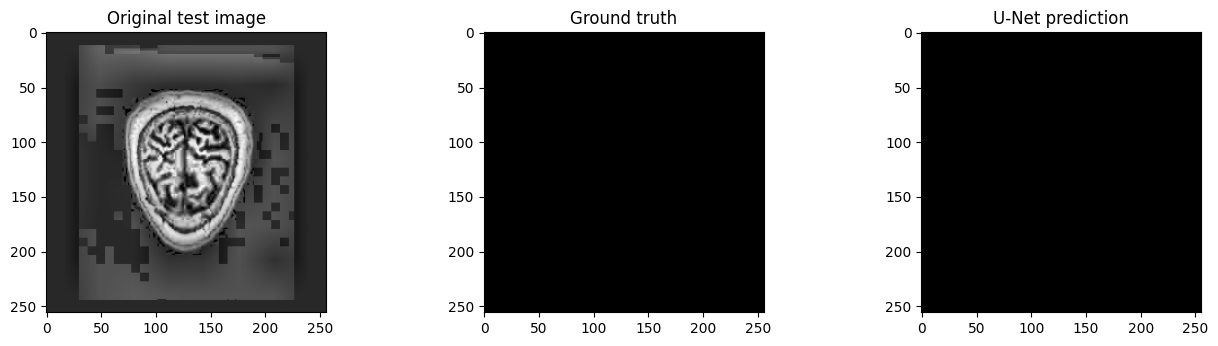

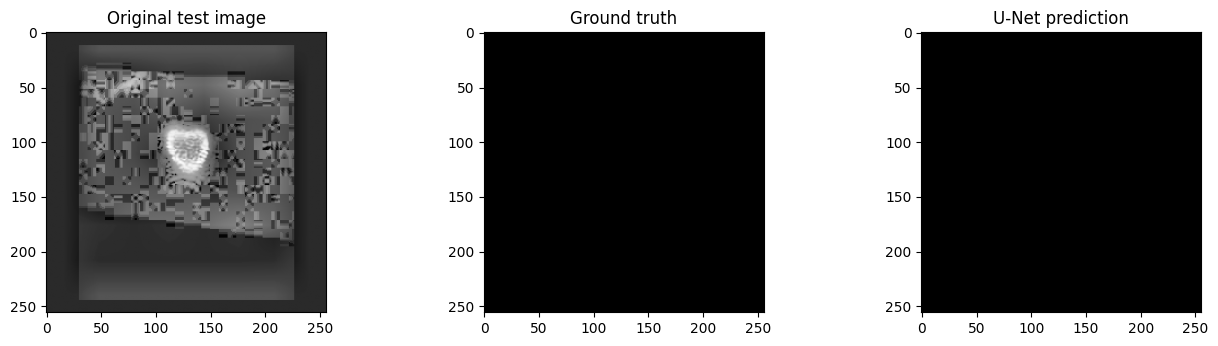

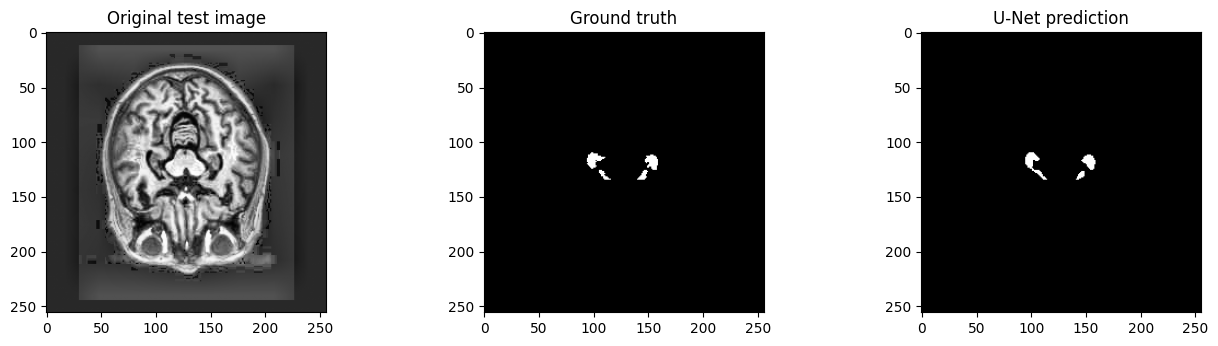

In [47]:
plot_test(model)


# Attention UNet

In [48]:
class AttentionUNet:
    def __init__(self,
                 base_filters=16,
                 dropout_rate=0.1,
                 activation='relu',
                 kernel_initializer='he_normal'):
        self.base_filters = base_filters
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.kernel_initializer = kernel_initializer


    def conv_block(self, x, filters):
        x = layers.Conv2D(filters, (3, 3), activation=self.activation, kernel_initializer=self.kernel_initializer, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3, 3), activation=self.activation, kernel_initializer=self.kernel_initializer, padding='same')(x)
        x = layers.BatchNormalization()(x)
        return x


    def attention_gate(self, x, g, inter_channels=None):
        if inter_channels is None:
            inter_channels = x.shape[-1] // 2
            if inter_channels < 1:
                inter_channels = 1

        # Linear projections of x and g
        theta_x = layers.Conv2D(inter_channels, (1, 1),
                                padding='same',
                                kernel_initializer=self.kernel_initializer,
                                use_bias=True)(x)

        phi_g = layers.Conv2D(inter_channels, (1, 1),
                                padding='same',
                                kernel_initializer=self.kernel_initializer,
                                use_bias=True)(g)

        theta_x = layers.BatchNormalization()(theta_x)
        phi_g   = layers.BatchNormalization()(phi_g)
        add_xg = layers.Add()([theta_x, phi_g])    # Add & nonlinearity
        act_xg = layers.Activation('relu')(add_xg)

        # Single attention map
        psi = layers.Conv2D(1, (1, 1),
                            padding='same',
                            kernel_initializer=self.kernel_initializer,
                            use_bias=True)(act_xg)
        psi = layers.BatchNormalization()(psi)
        psi = layers.Activation('sigmoid')(psi)
        y = layers.Multiply()([x, psi])     # Element-wise multiply attention map with the skip connection
        return y

    def build_attention_unet(self, img_height, img_width, img_channels):
        f = self.base_filters
        dr = self.dropout_rate

        inputs = Input(shape=(img_height, img_width, img_channels))
        # Encoder
        c1 = self.conv_block(inputs, f)
        p1 = layers.MaxPooling2D((2, 2))(c1)
        if dr and dr > 0:
            p1 = layers.Dropout(0.1)(p1)

        c2 = self.conv_block(p1, f * 2)
        p2 = layers.MaxPooling2D((2, 2))(c2)
        if dr and dr > 0:
            p2 = layers.Dropout(0.1)(p2)

        c3 = self.conv_block(p2, f * 4)
        p3 = layers.MaxPooling2D((2, 2))(c3)
        if dr and dr > 0:
            p3 = layers.Dropout(0.2)(p3)

        c4 = self.conv_block(p3, f * 8)
        p4 = layers.MaxPooling2D((2, 2))(c4)
        if dr and dr > 0:
            p4 = layers.Dropout(0.2)(p4)

        c5 = self.conv_block(p4, f * 16)
        p5 = layers.MaxPooling2D((2, 2))(c5)
        if dr and dr > 0:
            p5 = layers.Dropout(0.3)(p5)

        # Bottleneck
        c6 = self.conv_block(p5, f * 32)
        if dr and dr > 0:
            c6 = layers.Dropout(0.3)(c6)

        # Decoder
        u7 = layers.Conv2DTranspose(f * 16, (2, 2), strides=(2, 2), padding='same')(c6)
        c5_att = self.attention_gate(c5, u7, inter_channels=f * 8)
        u7 = layers.Concatenate()([u7, c5_att])
        if dr and dr > 0:
            u7 = layers.Dropout(0.3)(u7)
        c7 = self.conv_block(u7, f * 16)

        u8 = layers.Conv2DTranspose(f * 8, (2, 2), strides=(2, 2), padding='same')(c7)
        c4_att = self.attention_gate(c4, u8, inter_channels=f * 4)
        u8 = layers.Concatenate()([u8, c4_att])
        if dr and dr > 0:
            u8 = layers.Dropout(0.2)(u8)
        c8 = self.conv_block(u8, f * 8)

        u9 = layers.Conv2DTranspose(f * 4, (2, 2), strides=(2, 2), padding='same')(c8)
        c3_att = self.attention_gate(c3, u9, inter_channels=f * 2)
        u9 = layers.Concatenate()([u9, c3_att])
        if dr and dr > 0:
            u9 = layers.Dropout(0.2)(u9)
        c9 = self.conv_block(u9, f * 4)

        u10 = layers.Conv2DTranspose(f * 2, (2, 2), strides=(2, 2), padding='same')(c9)
        c2_att = self.attention_gate(c2, u10, inter_channels=f)
        u10 = layers.Concatenate()([u10, c2_att])
        if dr and dr > 0:
            u10 = layers.Dropout(0.1)(u10)
        c10 = self.conv_block(u10, f * 2)

        u11 = layers.Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(c10)
        c1_att = self.attention_gate(c1, u11, inter_channels=max(f // 2, 1))
        u11 = layers.Concatenate()([u11, c1_att])
        if dr and dr > 0:
            u11 = layers.Dropout(0.1)(u11)
        c11 = self.conv_block(u11, f)

        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

        model = Model(inputs=inputs, outputs=outputs, name="AttentionUNet")
        return model


In [49]:
att_unet = AttentionUNet(base_filters=16)
model_att = att_unet.build_attention_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [50]:
model_att.summary()

Model: "AttentionUNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128, 128,  │          0 │ max_pooling2d_5[… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │      4,640 │ dropout_11[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64, 64,    │          0 │ max_pooling2d_6[… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 64,    │     18,496 │ dropout_12[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_28[0][0] 

 Total params: 7,877,394 (30.05 MB)

 Trainable params: 7,870,376 (30.02 MB)

 Non-trainable params: 7,018 (27.41 KB)

In [51]:
model_att.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
               loss = 'binary_crossentropy',
               metrics = [metric_iou, metric_dice])
history_att = model_att.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        batch_size = BATCH_SIZE,
                        verbose = 1,
                        epochs = EPOCH)#, shuffle = True)


Epoch 1/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 97s 229ms/step - loss: 0.6633 - metric_dice: 0.0028 - metric_iou: 0.0014 - val_loss: 0.3913 - val_metric_dice: 0.1200 - val_metric_iou: 0.1200
Epoch 2/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - loss: 0.3178 - metric_dice: 8.0611e-05 - metric_iou: 4.0514e-05 - val_loss: 0.1650 - val_metric_dice: 0.1200 - val_metric_iou: 0.1200
Epoch 3/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - loss: 0.1369 - metric_dice: 0.0736 - metric_iou: 0.0477 - val_loss: 0.0747 - val_metric_dice: 0.2230 - val_metric_iou: 0.1771
Epoch 4/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - loss: 0.0646 - metric_dice: 0.6544 - metric_iou: 0.4879 - val_loss: 0.0407 - val_metric_dice: 0.4364 - val_metric_iou: 0.3256
Epoch 5/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - loss: 0.0359 - metric_dice: 0.7227 - metric_iou: 0.5669 - val_loss: 0.0248 - val_metric_dice: 0.7485 - val_metric_iou: 0.6196
Epoch 6/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - loss: 0.0225 - metric_dic

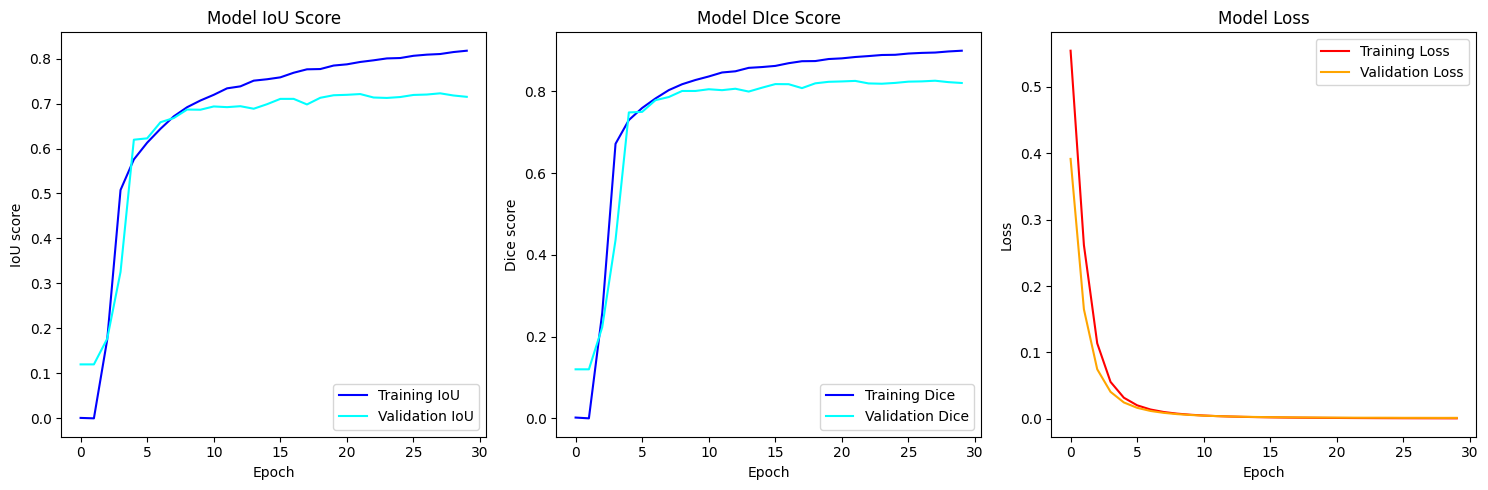

In [52]:
plot_train1(history_att)


In [53]:
eval_model(model_att, X_test, y_test)


(0.0012589176185429096, 0.7197909355163574, 0.82402503490448)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


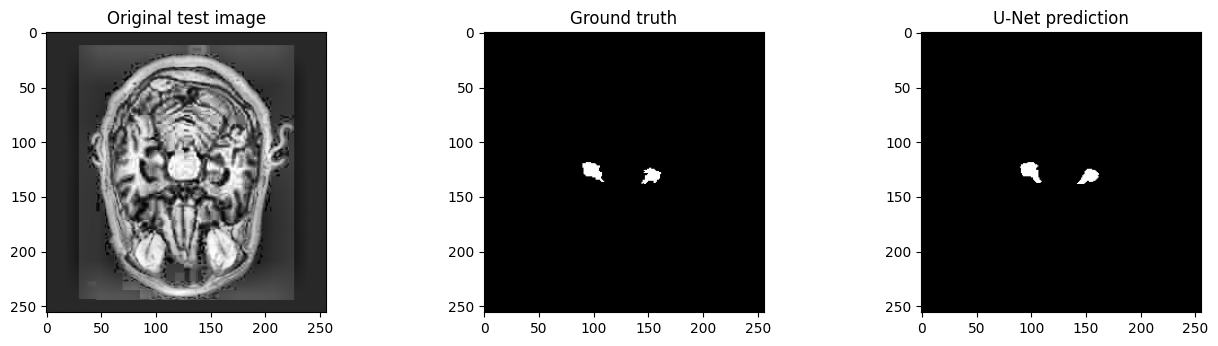

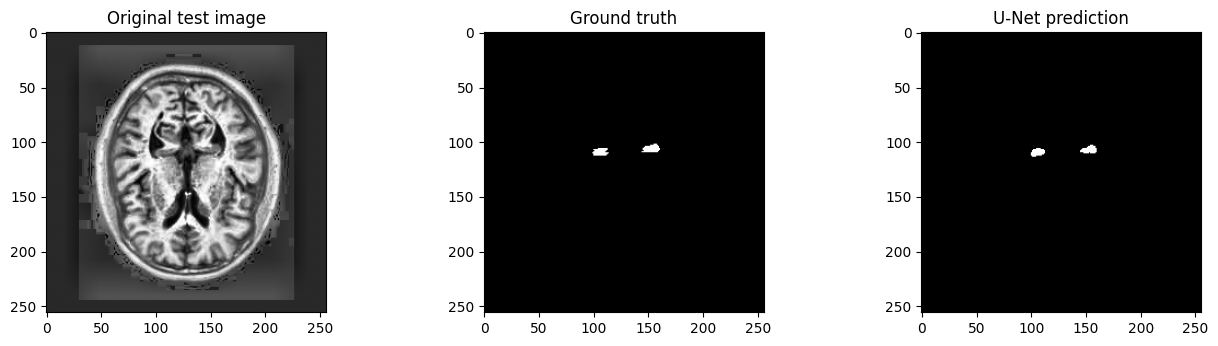

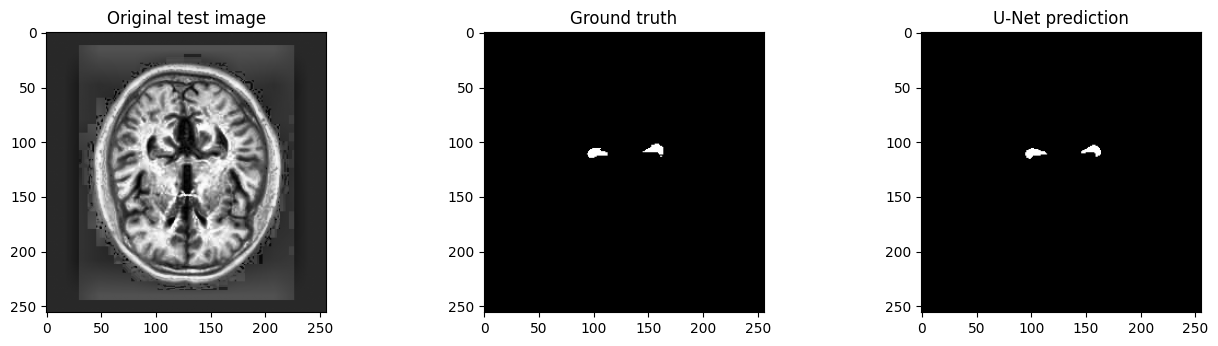

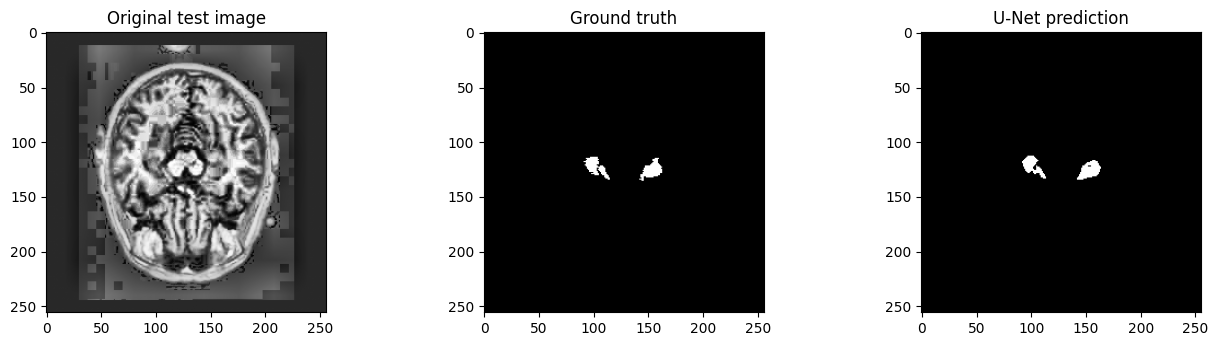

In [54]:
plot_test(model_att)


# CROSSVAL

In [ ]:
def patient_kfold_indices(patient_ids, n_splits=5, seed=42):
    patient_ids = np.array(patient_ids)
    unique_pats = np.unique(patient_ids)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for train_pat_idx, test_pat_idx in kf.split(unique_pats):
        train_pats = unique_pats[train_pat_idx]
        test_pats  = unique_pats[test_pat_idx]

        train_mask = np.isin(patient_ids, train_pats)
        test_mask  = np.isin(patient_ids, test_pats)

        train_idx = np.where(train_mask)[0]
        test_idx  = np.where(test_mask)[0]

        yield train_idx, test_idx


In [ ]:
def build_unet_model():
    unet = UNet1(base_filters=32)
    model = unet.build_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[metric_iou, metric_dice])
    return model


In [ ]:
def train_kfold_patient_level(X, Y, patient_ids,
                              model_func=build_unet_model,
                              n_splits=5,
                              epochs=EPOCH,
                              batch_size=BATCH_SIZE,
                              seed=42):

    patient_ids = np.array(patient_ids)
    list_loss = []
    list_iou = []
    list_dice = []

    for fold, (train_idx, test_idx) in enumerate(patient_kfold_indices(patient_ids, n_splits=n_splits, seed=seed), start=1):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        train_ds = make_train_dataset(X_train, Y_train, batch_size=BATCH_SIZE, augment=True)

        model = model_func()
        model.fit(
            train_ds,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0)

        loss, iou, dice = eval_model(model, X_test, Y_test)
        list_loss.append(loss)
        list_iou.append(iou)
        list_dice.append(dice)

    df_metrics = pd.DataFrame({
        'fold': range(1, n_splits + 1),
        'loss':  [round(v, 4) for v in list_loss],
        'iou':  [round(v, 4) for v in list_iou],
        'dice': [round(v, 4) for v in list_dice],})

    return df_metrics


In [ ]:
df_cv = train_kfold_patient_level(x, y,
                        model_func=build_unet_model,
                        patient_ids=selected_patient_id,
                        n_splits=5)

df_cv


,fold,loss,iou,dice
0,1,0.0013,0.6998,0.8098
1,2,0.0013,0.7006,0.8120
2,3,0.0011,0.6293,0.7340
3,4,0.0011,0.7136,0.8228
4,5,0.0011,0.6900,0.8029


In [ ]:
def build_att_unet_model():
    att_unet = AttentionUNet(base_filters=16,
                         dropout_rate=0.2)
    model_att = att_unet.build_attention_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    model_att.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
               loss = 'binary_crossentropy',
               metrics = [metric_iou, metric_dice])
    return model_att

In [ ]:
df_cv1 = train_kfold_patient_level(x, y,
                        model_func=build_att_unet_model,
                        patient_ids=selected_patient_id,
                        n_splits=5)

df_cv1


,fold,loss,iou,dice
0,1,0.0014,0.6595,0.7735
1,2,0.0015,0.6759,0.7925
2,3,0.0013,0.6270,0.7345
3,4,0.0012,0.6888,0.8031
4,5,0.0013,0.6662,0.7847


In [ ]:
df_cv1['iou'].mean(), df_cv1['dice'].mean()

(np.float64(0.66348), np.float64(0.77766))

# Post processing

In [ ]:
def postprocessing(mask, threshold=0.5):
    mask = (mask > threshold).astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    mask = np.expand_dims(cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel), 2)  # Opening
    mask = np.expand_dims(cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel), 2)  # Closing
    return mask

# Test different loss

In [ ]:
# def bce_dice_loss(y_true, y_pred, bce_weight=0.5, smooth=1e-6):         # Gives better result to model (use smaller dataset)
#     bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

#     intersection = tf.reduce_sum(y_true * y_pred)
#     union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
#     dice = (2 * intersection + smooth) / (union + smooth)
#     dice_loss = 1 - dice
#     return bce_weight * bce + (1 - bce_weight) * dice_loss


# NOTES
* Although we have quite large size of the original dataset, due to resource limitation, we have to reduce its size. However, the result seems promising given 1/3 of the original data & only 30 epochs of training
* Before getting the current model, several experiments were conducted particularly regarding model architecture complexity. Final modelused fewer blocks than previously tried models, yet gave the best result (all without batch normalization layer). Num of blocks: 5 in encoder & decoder, 1 in bottleneck (1 block deeper than original UNet paper)
* Addition of batch normalization layer boosts the performance. Placement of batchnorm layer after activation gives better result than before it.
* Model performs differently with different combination of preprocessing methods. Latest experiment was only using Contrast Limited Adaptive Histogram Equalization (CLAHE) & normalization; also adding data augmentation on the fly during training (horizontal flip to avoid much distortion of anatomical shape)
* Bce dice loss gives better result than bce (in the previous model, but has not been trained again with the latest model)
* Smaller batch size, the better the learning process despite longer training time.

What's next:
* If possible, use all data
* (v) Implement Attention UNet
* (v) Ensure patient level split for train & test
* Try different loss: Weighted bce, dice, tversky, focal (& some combinations)
* More post processing, apart from adjusting threshold
* Tuning Attention UNet (bcs too focused on tuning basic UNet before)
* More analytic metrics: Haussdorf Distance, recall, precision. Also ensure metric computation on patient/case-level instead of random batch, & report separately between data with original/predicted foreground & background-only
